In [2]:
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
print("start!")
HIDDEN_SIZE = 64
BATCH_SIZE = 64 # 64
LOG_ITERATIONS = 500
EPOCHS_NUM = 40

start!


In [0]:
# from google.colab import files, drive
# drive.mount('/content/gdrive')
# torch.save(encoder1.state_dict(), "gdrive/My Drive/CompLing/rusdeu10_beam_encoder1.dic")
# print("Hello stackoverflow!", file=open("gdrive/My Drive/CompLing/output.txt", "a"))

In [0]:
# f = open("gdrive/My Drive/CompLing/output.txt", 'a+')
# f.write("Appended line, lol\r\n")
# f.close()
# with open("gdrive/My Drive/CompLing/output.txt", 'a') as f:
#   f.write("Appended line\r\n")
# f.write("Here\r\n")

## План
1. Разбить датасет на трейн/тест или на трейн/валидация/тест, как вам больше нравится
1. Сделать класс нейронки, вписать необходимые операции, базовая архитектура ниже
1. Написать обучалку
1. Добавить логирование
    1. Сохранять лосс на каждой итерции обучения __0.25 балла__
    1. Каждую эпоху сохранять лосс трейна и тест __0.25 балла__
    1. Каждую эпоху рассчитывать метрики __0.25 балла__
    1. Добавить прогресс бар, в котором показывается усредненный лосс последних 500-та итераций __0.25 балла__
1. Добавить early stopping __0.5 балла__
1. Отрисовать графики лосса, метрик, конфьюжин матрицу __0.5 балла__
1. Улучшить результат. Например, можно добавить BatchNorm, Dropout, Residual, etc __1 балл__
1. Сделать макро f1 больше 0.8 __1 балл__
1. Написать какие действия к чему приводили (почему вы их делали и оправдались ли ожидания)

## Базовая архитектура
1. Предобученные эмбеддинги. Почитайте [здесь](https://pytorch.org/docs/stable/nn.html#embedding) (from_pretrained) как вставить свои эмбеддинги, выше мы читали матрицу эмбеддингов. __1 балл__
1. Bidirectional LSTM. __1 балл__
2. Несколько параллельных CNN с разными размерами окна и пулингами к ним. __2 балла__
3. Конкатенация результатов CNN. __0 баллов__ (идет вместе с предыдущим пунктом)
4. Предикт в количество классов. __0 баллов__ (ну все-таки предсказать классы нужно обязательно)

__Дополнительные баллы:__
- Написать GRU с нуля самому __1 балл__
- Побить макро f1 0.84 __1 балл__
- Переобучиться и снизить переобучение за счет трюков. Пояснение: показываете, что вот такая архитектура переобучается, а вот я добавил/а это и это, изменил/а это и это и переобучение ушло __1 балл__
- Добавить селф аттеншин (написанный своими руками) __3 балла__
- За мультихед селф аттеншин еще __1 балл__
- Добавить [torch.nn.utils.rnn.pack_padded_sequence()](https://pytorch.org/docs/stable/nn.html#torch.nn.utils.rnn.pack_padded_sequence) и [torch.nn.utils.rnn.pack_sequence()](https://pytorch.org/docs/stable/nn.html#torch.nn.utils.rnn.pack_sequence) для LSTM. Инфа [здесь](#Еще-важный-момент-про-LSTM) __2 балла__
- Добавить дропаут для входа LSTM (не просто стандартный пункт при инициализации LSTM) __1 балл__
- Добавить шедуллеры __1 балл__
- your madness

### TIPs:
- Если будете брать ```train_test_split```, не забудьте сделать ```reset_index```, чтобы по индексу корректно доставались таргеты из ```y_data```  
- Необязательно делить датасет именно на 70 % и 30 %  
- Пулинг можно делать без торчового слоя

# РАЗМЕР ТЕСТА НЕ МЕНЬШЕ 10% ДАТАСЕТА
# 10 БАЛЛОВ МАКСИМУМ

In [5]:
!pip install pandas
!pip install torch
!pip install nltk
!pip install tqdm
!pip install seaborn
!pip install numpy
!pip install sklearn
!pip install pytorch-ignite


     |████████████████████████████████| 92kB 2.9MB/s 


In [6]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Скачиваем данные

In [7]:
!wget https://github.com/BobaZooba/HSE-Deep-Learning-in-NLP-Course/blob/master/week_05/data/answers_subsample.csv?raw=true -O data.csv

--2019-10-27 18:44:52--  https://github.com/BobaZooba/HSE-Deep-Learning-in-NLP-Course/blob/master/week_05/data/answers_subsample.csv?raw=true
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/BobaZooba/HSE-Deep-Learning-in-NLP-Course/raw/master/week_05/data/answers_subsample.csv [following]
--2019-10-27 18:44:53--  https://github.com/BobaZooba/HSE-Deep-Learning-in-NLP-Course/raw/master/week_05/data/answers_subsample.csv
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/BobaZooba/HSE-Deep-Learning-in-NLP-Course/master/week_05/data/answers_subsample.csv [following]
--2019-10-27 18:44:53--  https://raw.githubusercontent.com/BobaZooba/HSE-Deep-Learning-in-NLP-Course/master/week_05/data/answers_subsample.csv
Resolving raw.githubusercontent.com (raw.github

In [0]:
# если ругается на то, что нет wget
# !apt-get install wget

In [9]:
!ls -l

total 28052
-rw-r--r-- 1 root root 28717126 Oct 27 18:44 data.csv
drwxr-xr-x 1 root root     4096 Oct 22 15:18 sample_data


In [0]:
import pandas as pd

In [0]:
data = pd.read_csv('data.csv').reset_index()

In [0]:
# data

In [0]:
import re
puncts  = str.maketrans('','',":,?;\"!.«»()\'\*\+\\\/\>\<\=")
def smileproc(b):
  b = re.sub(r"(?<=[А-ЯЁа-яё\d])(?=\))", " ", b)    

  eyes, noses, mouths = r":;8BX=", r"-~'^", r")(/\|DP"
  patsmileys = "[%s][%s]?[%s]" % tuple(map(re.escape, [eyes, noses, mouths]))
  j = re.findall(patsmileys, b)
  patsmile = r"\s\)+"
  h = re.findall(patsmile, b)
  b = re.sub(r"\?", " СПРАШИВАЮ ", b)
  b = re.sub(r"\!", " ВАЖНО ", b)
  if j:
    b = re.sub(patsmileys, " УЛЫБАЮСЬ ", b)
    # print (j, b)
  if h and b.count('(') == 0:
    b = re.sub(patsmile, " УЛЫБАЮСЬ ", b)
    b = re.sub(r"о_о", " УЛЫБАЮСЬ ", b)
    
    # print (h, b)
  b = b.lower().translate(puncts).strip()      
  b = re.sub(r'(?<=\\d)(?=\\w)|(?<=\\w)(?=\\d)', ' ', b)
  return b

In [14]:
%%time
DATA_TEXTS = data.text.tolist()
# for a, row in data.iterrows():  
for a, b in enumerate(DATA_TEXTS):
  # s = row["text"]
  s = b
  # if a > 5000: break
  # if a % 1000 == 0:
  #   print(a)
  res = smileproc(s)
  # data.loc[a, "text"] = res
  DATA_TEXTS[a] = res
  # print(res)


CPU times: user 6.18 s, sys: 35.2 ms, total: 6.22 s
Wall time: 6.24 s


In [0]:
# for a, b in enumerate(data.text):
#   if a > 500: break
#   print(b)
# for a, b in enumerate(tts):
#   if a > 500: break
#   print(b)

In [16]:
data.category.value_counts() * 100 / data.shape[0]

law         29.793211
relax       22.016242
business    19.309527
food        18.367055
love        10.513965
Name: category, dtype: float64

# Предобученные эмбеддинги
[Источник](https://fasttext.cc/docs/en/crawl-vectors.html)  
Вы можете взять любые word2vec подобные эмббединги. Если вы хотите использовать elmo, bert, etc сначала попробуйте с word2vec подобными эмббедингами, а потом можете перейти к более сложным моделям.  
Ниже мы сначала скачиваем, а потом распоковываем эмбеддинги.

In [17]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ru.300.vec.gz
!gzip -d cc.ru.300.vec.gz

--2019-10-27 18:45:09--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ru.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.20.6.166, 104.20.22.166, 2606:4700:10::6814:6a6, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.20.6.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1306357571 (1.2G) [binary/octet-stream]
Saving to: ‘cc.ru.300.vec.gz’

cc.ru.300.vec.gz    100%[===================>]   1.22G  14.1MB/s    in 90s     

2019-10-27 18:46:41 (13.8 MB/s) - ‘cc.ru.300.vec.gz’ saved [1306357571/1306357571]



In [18]:
!ls -l

total 4458144
-rw-r--r-- 1 root root 4536408847 Jan 18  2019 cc.ru.300.vec
-rw-r--r-- 1 root root   28717126 Oct 27 18:44 data.csv
drwxr-xr-x 1 root root       4096 Oct 22 15:18 sample_data


In [0]:
from nltk.tokenize import word_tokenize, wordpunct_tokenize
from tqdm import tqdm

In [0]:
# потом можете добавить свою предобработку

def process_text(text):    
    words = wordpunct_tokenize(text.lower())
    
    return words

In [21]:
word2freq = {}
lengths = []

# for text in tqdm(data.text):
for text in tqdm(DATA_TEXTS):
    
    words = process_text(text)
    
    lengths.append(len(words))
    
    for word in words:
        
        if word in word2freq:
            word2freq[word] += 1
        else:
            word2freq[word] = 1

100%|██████████| 237779/237779 [00:02<00:00, 110258.43it/s]


In [0]:
import seaborn as sns
from matplotlib import pyplot as plt

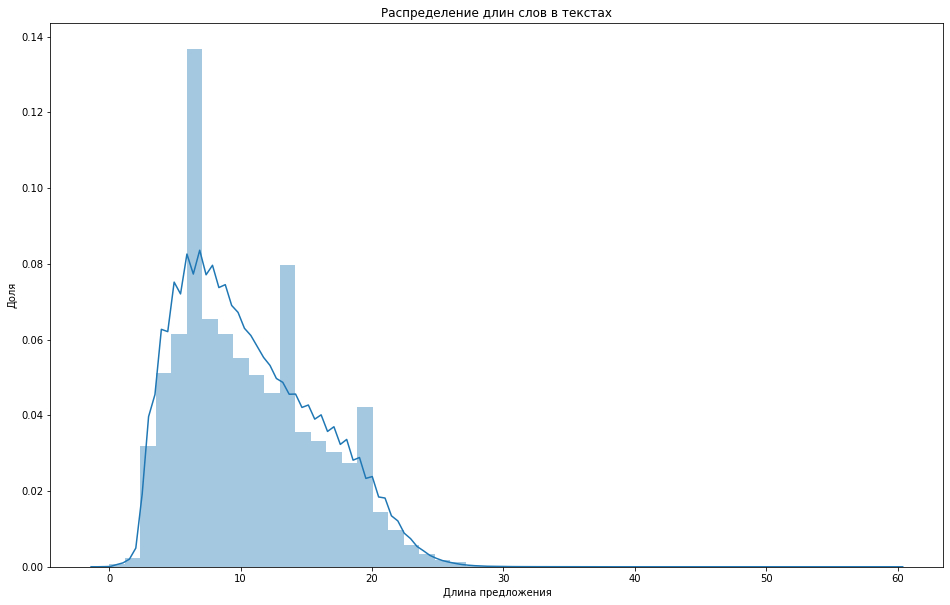

In [23]:
plt.figure(figsize=(16, 10))
plt.title('Распределение длин слов в текстах')
plt.xlabel('Длина предложения')
plt.ylabel('Доля')
sns.distplot(lengths)

In [24]:
upper_threshold = 32
lower_threshold = 3

correct_percent = len([sent_len for sent_len in lengths 
                       if sent_len <= upper_threshold and sent_len >= lower_threshold]) * 100 / len(lengths)

'{:.2f} % наших текстов входят в промежуток от {} до {} слов'.format(correct_percent, lower_threshold, upper_threshold)

'99.63 % наших текстов входят в промежуток от 3 до 32 слов'

In [25]:
len(word2freq)

155101

In [26]:
'{} слов, которые встречались 3 и менее раз'.format(len([word for word in word2freq if word2freq[word] <= 3]))

'117640 слов, которые встречались 3 и менее раз'

# Читаем файл с эмбеддингами
### Этот файл с 300 числами для 2 000 000 слов и он может не влезть в память
Поэтому прочитаем только те слова, которые мы знаем

In [0]:
import numpy as np

In [28]:
word2index = {'PAD': 0}
vectors = []
    
word2vec_file = open('cc.ru.300.vec')
    
n_words, embedding_dim = word2vec_file.readline().split()
n_words, embedding_dim = int(n_words), int(embedding_dim)

# Zero vector for PAD
vectors.append(np.zeros((1, embedding_dim)))

progress_bar = tqdm(desc='Read word2vec', total=n_words)

while True:

    line = word2vec_file.readline().strip()

    if not line:
        break
        
    current_parts = line.split()

    current_word = ' '.join(current_parts[:-embedding_dim])

    if current_word in word2freq:

        word2index[current_word] = len(word2index)

        current_vectors = current_parts[-embedding_dim:]
        current_vectors = np.array(list(map(float, current_vectors)))
        current_vectors = np.expand_dims(current_vectors, 0)

        vectors.append(current_vectors)

    progress_bar.update(1)

progress_bar.close()

word2vec_file.close()

vectors = np.concatenate(vectors)

Read word2vec: 100%|██████████| 2000000/2000000 [01:05<00:00, 30377.07it/s]


In [29]:
len(word2index)

117572

In [30]:
unk_words = [word for word in word2freq if word not in word2index]
unk_counts = [word2freq[word] for word in unk_words]
n_unk = sum(unk_counts) * 100 / sum(list(word2freq.values()))

sub_sample_unk_words = {word: word2freq[word] for word in unk_words}
sorted_unk_words = list(sorted(sub_sample_unk_words, key=lambda x: sub_sample_unk_words[x], reverse=True))

print('Мы не знаем {:.2f} % слов в датасете'.format(n_unk))
print('Количество неизвестных слов {} из {}, то есть {:.2f} % уникальных слов в словаре'.format(
    len(unk_words), len(word2freq), len(unk_words) * 100 / len(word2freq)))
print('В среднем каждое встречается {:.2f} раз'.format(np.mean(unk_counts)))
print()
print('Топ 5 невошедших слов:')

for i in range(50):
    print(sorted_unk_words[i], 'с количеством вхождениий -', word2freq[sorted_unk_words[i]])

Мы не знаем 1.71 % слов в датасете
Количество неизвестных слов 37530 из 155101, то есть 24.20 % уникальных слов в словаре
В среднем каждое встречается 1.16 раз

Топ 5 невошедших слов:
дошик с количеством вхождениий - 43
егрн с количеством вхождениий - 40
слайм с количеством вхождениий - 39
внп с количеством вхождениий - 37
девчин с количеством вхождениий - 36
♪♫ с количеством вхождениий - 31
wwwyoutubecomwatch с количеством вхождениий - 25
hatsan с количеством вхождениий - 25
%- с количеством вхождениий - 23
сзв с количеством вхождениий - 19
комиссация с количеством вхождениий - 18
кафересторан с количеством вхождениий - 18
кдн с количеством вхождениий - 17
boozled с количеством вхождениий - 17
фкз с количеством вхождениий - 16
помогитее с количеством вхождениий - 15
быстроденьги с количеством вхождениий - 15
```` с количеством вхождениий - 15
бсо с количеством вхождениий - 15
алиекспресс с количеством вхождениий - 15
` с количеством вхождениий - 14
слаймов с количеством вхождениий - 1

# Потеря 2.5 % слов в датасете
Эта ситуация не то, чтобы сильно плохая, в учебных целях нормально, к тому же в среднем они редко встречаются. Вы можете поиграть с предобработкой, но советую не заигрываться. Оценивается другое.

In [0]:
import torch

# Подготовим данные в DataLoader

In [0]:
from torch.utils.data import Dataset, DataLoader

In [33]:
'UNK' in word2index

False

# Замапим категории в индексы

In [0]:
cat_mapper = {cat: n for n, cat in enumerate(data.category.unique())}
inv_cat_mapper =  {v: k for k, v in cat_mapper.items()}

In [35]:
inv_cat_mapper.keys()

dict_keys([0, 1, 2, 3, 4])

In [36]:
cat_mapper

{'business': 0, 'food': 4, 'law': 1, 'love': 2, 'relax': 3}

In [37]:
len(cat_mapper)

5

In [0]:
data_cats = data.category.map(cat_mapper)

In [0]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(DATA_TEXTS, data_cats.tolist(), test_size=0.2)

In [40]:
x_train[:10]

['как правильно узнать дальнейшую судьбу с момента отказа зам прокурора  моего возвращенного дела спрашиваю  какие мои действия спрашиваю',
 'у кого 1с розница - какой ккт вы применяете',
 'мне 16 лет мы общаемся с девушкой и любим друг друга я хочу к ней приехать к ней но она в другой стране',
 'нужно взять справку о составе семьи в жкх её дадут если мне 15 лет и я приду с паспортом спрашиваю',
 'стоит ли играть с ней на раздевание в шахматы спрашиваю улыбаюсь  или пусть просто раздевается и все спрашиваю  все равно играть не умеет небось улыбаюсь',
 'сроки расчета при увольнении',
 '22 так и не встретил свою вторую половинку жить скучно одному',
 'удаленное отчуждение прав на квартиру',
 'считается ли соучастием спрашиваю  очень прошу помогите',
 'какую материальную ответственность несет работник который получил товар по накладной спрашиваю  товар был украден неизвестными']

In [41]:
y_train[:10]


[1, 0, 2, 1, 2, 1, 2, 1, 1, 1]

# Читалка данных

## Что происходит ниже
1. Мы задаем x_data, y_data (таргеты), word2index (маппер из слова в индекс слова), sequence_length (максимальная длина последовательности, если больше, ограничить ею), pad_token (токен паддинга и задаем его индекс pad_index).
1. Загружаем данные:
    1. Проходимся по датасету
    1. Предобрабатываем каждый текст в датасете
    1. Индексируем его
1. Когда нам нужно достать пример из датасета мы берем индексированный ```x``` и соответствующий этому индексу ```y```, наш ```x``` также паддим (или ограничиваем длину) и переводим в ```torch.Tensor(x).long()```. Для ```y``` этого делать не потребуется, в dataloader'е таргеты преобразуются в тензор сами.
    
## Что нужно сделать здесь
1. Дописать индексатор текста
1. Дописать паддинг текста
1. __*Опционально:*__ добавить что-то в предобработку

In [0]:
from itertools import repeat

In [0]:
class WordData(Dataset):
    
    def __init__(self, x_data, y_data, word2index, sequence_length=32, pad_token='PAD', verbose=True):
        
        super().__init__()
        
        self.x_data = []
        self.y_data = []
        
        self.word2index = word2index
        self.sequence_length = sequence_length
        
        self.pad_token = pad_token
        self.pad_index = self.word2index[self.pad_token]
        
        self.load(x_data, y_data, verbose=verbose)
        
    @staticmethod
    def process_text(text):
        
        # Место для вашей предобработки        
        # aftertext = text.lower().translate(puncts).strip()        
        # words = wordpunct_tokenize(digisep(aftertext))

        words = wordpunct_tokenize(text)

        return words
        
    def load(self, data, data2, verbose=True):
        
        data_iterator = tqdm(range(len(data)), desc='Loading data', disable=not verbose, position=0)
        
        for i in data_iterator:
            
            words = self.process_text(data[i])
            
            indexed_words = self.indexing(words)
            if indexed_words:
              self.x_data.append(indexed_words)
              self.y_data.append(data2[i])
              # print("O_o")
            
            
    
    def indexing(self, tokenized_text):

        # здесь мы не используем токен UNK, потому что мы мы его специально не учили
        # становится непонятно какой же эмбеддинг присвоить неизвестному слову,
        # поэтому просто выбрасываем наши неизветсные слова        
        ### CODE ###
        return [self.word2index[token] for token in tokenized_text if token in self.word2index]
        
            
    def padding(self, sequence):
        
        # Ограничить длину self.sequence_length
        # если длина меньше максимально - западить
        ### CODE ###        
        delta = self.sequence_length - len(sequence)
        return sequence + list(repeat(self.pad_index, delta)) \
        if delta > 0 else sequence[:self.sequence_length]

    def __len__(self):
        
        return len(self.x_data)
    
    def __getitem__(self, idx):
        
        x = self.x_data[idx]
        x = self.padding(x)
        x = torch.Tensor(x).long()
        
        y = self.y_data[idx]
        
        return x, y

In [44]:
dataset = WordData(x_train, y_train, word2index)
datasettest = WordData(x_test, y_test, word2index)
# dataset = WordData(data.text, data.category, word2index)


Loading data: 100%|██████████| 47556/47556 [00:00<00:00, 106540.24it/s]


In [0]:
train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, pin_memory=True)
test_loader = DataLoader(datasettest, batch_size=BATCH_SIZE, pin_memory=True)

In [0]:
import warnings
warnings.filterwarnings('ignore')
# warnings break progress bar

In [187]:
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
torch.set_printoptions(profile="full")

def nsort(y):
  ll, ii = (y > 0).sum(1).sort(descending=True)
  return y[ii], ll

def tsort(ts):
  z = torch.tensor([len(torch.nonzero(ts[i])) for i in range(ts.shape[0])]).sort(descending=True)
  return ts[z[1]], z[0], np.argsort(z[1]).to(device)

class CoolNet(nn.Module):
  """
  |￣￣￣￣￣￣￣￣￣￣￣|
    I don't know
    what I am doing,
    but it is my neural
    network
  |＿＿＿＿＿＿＿＿＿＿＿|
  (\__/) ||
  (•ㅅ•) ||
  / 　 づ
  """
 
  def __init__(self, vocab_size, hidden_dim, classes_quantity, emb_weights, seqlen = 32, debug_file=None):
    super().__init__()
    self.embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(emb_weights))
    self.drop = nn.Dropout2d(0.25)    
    embedding_length  = emb_weights.shape[1]
    self.lstm = nn.LSTM(input_size=embedding_length,\
                        hidden_size=hidden_dim,\
                        bidirectional=True, batch_first=True)
    self.linear = nn.Linear(hidden_dim*2, classes_quantity)    

    kerns = [2,4,6,8]
    # con_size = embedding_length
    con_size = hidden_dim * 2

    self.conv1 = nn.Conv1d(in_channels=con_size, out_channels= hidden_dim, kernel_size=kerns[0])
    self.conv2 = nn.Conv1d(in_channels=con_size, out_channels= hidden_dim, kernel_size=kerns[1])
    self.conv3 = nn.Conv1d(in_channels=con_size, out_channels= hidden_dim, kernel_size=kerns[2])
    self.conv4 = nn.Conv1d(in_channels=con_size, out_channels= hidden_dim, kernel_size=kerns[3])

    self.mp1 = nn.MaxPool1d(kernel_size=(seqlen-kerns[0]+1))
    self.mp2 = nn.MaxPool1d(kernel_size=(seqlen-kerns[1]+1))
    self.mp3 = nn.MaxPool1d(kernel_size=(seqlen-kerns[2]+1))
    self.mp4 = nn.MaxPool1d(kernel_size=(seqlen-kerns[3]+1))
    self.relu = nn.ReLU()
    
    self.f  = debug_file
    pass



  def forward(self, x):    
    x_sorted, lens, unindex = tsort(x)
    # print("orig", x.shape, len(lens))
    x = self.embeddings(x_sorted)
    # x = self.embeddings(x)
    x = self.drop(x)   
    # print("emb", x.shape)
    z = pack_padded_sequence(x, lens, batch_first=True)
    x, _ =  self.lstm(z)
        # x, _ =  self.lstm(x)
        # x = x[:, -1, :]
    x, _ = pad_packed_sequence(x, batch_first=True)
    # print("lstm out", x.shape)
    x = x.index_select(0, unindex)
        # print("lstm2", x.shape)
    x = x.transpose(0, 1)

        # print("lstm3", x.shape)



    # x_transposed = x.transpose(1, 2) 
    
        # print("conv in", x_transposed.shape)

    # x1 = F.relu(self.conv1(x_transposed))
    # x2 = F.relu(self.conv2(x_transposed))
    # x3 = F.relu(self.conv3(x_transposed))
    # x4 = F.relu(self.conv4(x_transposed))

          # print("x1", x1.shape)
          # print("x2", x2.shape)
          # print("x3", x3.shape)
          # print("x4", x4.shape)

    # x1 = x1.transpose(0,2)
    # x2 = x2.transpose(0,2)
    # x3 = x3.transpose(0,2)
    # x4 = x4.transpose(0,2)
    
    # mp1x = self.mp1(x1)
    # mp2x = self.mp2(x2)
    # mp3x = self.mp3(x3)
    # mp4x = self.mp4(x4)

          # print("mp out", mp1x.shape)

    # x_cat = torch.cat((mp1x, mp2x, mp3x, mp4x), 0)
        # print("after cnn",x_cat.shape)
        # x = x_cat.transpose(1, 2)
        # print("cnn trans",x.shape)
    
    x = x[0]

    # x = x[:, -1, :]

    x = self.drop(x)
    x = self.linear(x)
    return x



# f = open("gdrive/My Drive/CompLing/output.txt", 'a+')
f = None



model = CoolNet(vocab_size=len(word2index), hidden_dim = HIDDEN_SIZE,\
                classes_quantity = len(cat_mapper),\
                emb_weights = vectors, debug_file=f)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# torch.cuda.empty_cache()
print("CUDA RAM usage", torch.cuda.max_memory_allocated(device))
model.to(device)
optimizer = torch.optim.Adam(params=model.parameters())
# aka loss function
criterion = torch.nn.CrossEntropyLoss()

CUDA RAM usage 6366603776


In [0]:
from ignite.engine import Engine, _prepare_batch, Events, create_supervised_evaluator
from ignite.metrics import Loss, Accuracy, Precision, Recall, Loss, ConfusionMatrix, IoU, MetricsLambda
from ignite.contrib.handlers import ProgressBar
from ignite.handlers import EarlyStopping
from torch.optim.lr_scheduler import ExponentialLR, CosineAnnealingWarmRestarts



lr_scheduler = ExponentialLR(optimizer, gamma=0.8)
# lr_scheduler = CosineAnnealingWarmRestarts(optimizer, T_0 = 2)

def f1(precision, recall):  
  #  + 1e-20
  # res = precision * recall * 2 / (precision + recall)
  # res = MetricsLambda(lambda t: torch.mean(t).item(), res)
  res = (precision * recall * 2 / (precision + recall)).mean()
  return res

log_interval = LOG_ITERATIONS
epochs = EPOCHS_NUM

metrics = {
    'avg_loss': Loss(criterion),
    'avg_accuracy': Accuracy(),
    'avg_precision': Precision(average=True),
    'avg_recall': Recall(average=True),
    'prec': Precision(average=False),
    'rec': Recall(average=False),
    'nll': Loss(criterion),
    'cm': ConfusionMatrix(num_classes=len(cat_mapper))
}

def process_function(engine, batch):
    model.train()
    optimizer.zero_grad()
    x, y = _prepare_batch(batch, device=device)
    y_pred = model(x)
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()
    return loss.item()

def create_supervised_evaluator(model, metrics={}, device=None):
    if device:
        model.to(device)

    def _inference(engine, batch):
        model.eval()
        with torch.no_grad():
            x, y = _prepare_batch(batch, device=device)
            y_pred = model(x)
            return y_pred, y

    engine = Engine(_inference)

    for name, metric in metrics.items():
        metric.attach(engine, name)

    return engine    
################################################################################
print("Current device", device)

train_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)
val_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)

# trainer = Engine(process_function)

from ignite.engine import create_supervised_trainer

trainer = create_supervised_trainer(model, optimizer, criterion, device)

training_history = {'accuracy':[],'loss':[], 'f1':[]}
validation_history = {'accuracy':[],'loss':[], 'f1':[]}
loss_history = []

def score_function(engine):
    # loss growth monitoring
    # val_loss = engine.state.metrics['nll']
    # return -val_loss
    # f1
    return f1(engine.state.metrics['prec'], engine.state.metrics['rec'])

early_stopping = EarlyStopping(patience=10, score_function=score_function, trainer=trainer)

val_evaluator.add_event_handler(Events.EPOCH_COMPLETED, early_stopping)

pbar = ProgressBar()
pbar.attach(trainer, output_transform=lambda x: {'loss': x})

# cm = ConfusionMatrix(num_classes=5)
# IoU(cm, ignore_index=0).attach(train_evaluator, 'IoU')

@trainer.on(Events.EPOCH_STARTED)
def update_lr_scheduler(engine):
    lr_scheduler.step()
    # Display learning rate:
    if len(optimizer.param_groups) == 1:
        lr = float(optimizer.param_groups[0]['lr'])
        print("Learning rate: {}".format(lr))
    else:
        for i, param_group in enumerate(optimizer.param_groups):
            lr = float(param_group['lr'])
            print("Learning rate (group {}): {}".format(i, lr))


@trainer.on(Events.ITERATION_COMPLETED)
def log_training_loss(engine):
    # f.close()
    iteration = (engine.state.iteration - 1) % len(train_loader) + 1
    loss_history.append(engine.state.output)
    if iteration % log_interval == 0:
        print("Epoch[{}] Iteration[{}/{}] Loss: {:.4f}"
              .format(engine.state.epoch, 
                         iteration, 
                         len(train_loader), 
                         engine.state.output))


@trainer.on(Events.EPOCH_COMPLETED)
def compute_and_display_offline_train_metrics(engine):
    epoch = engine.state.epoch
    print("Compute train metrics...")
    metrics = train_evaluator.run(train_loader).metrics
    f1val = f1(metrics['prec'], metrics['rec'])
    accuracy = metrics['avg_accuracy']
    training_history['accuracy'].append(accuracy)
    avgloss  = metrics['avg_loss']
    training_history['loss'].append(avgloss)
    training_history['f1'].append(f1)

  
    print("Training Results - Epoch: {}  Average Loss: {:.4f} | Accuracy: {:.4f} | Precision: {:.4f} | Recall: {:.4f}  | F1: {:.4f}"
          .format(engine.state.epoch, 
                      avgloss, 
                      metrics['avg_accuracy'], 
                      metrics['avg_precision'], 
                      metrics['avg_recall'],
                      f1val
                  ))

@trainer.on(Events.EPOCH_COMPLETED)
def compute_and_display_val_metrics(engine):
    epoch = engine.state.epoch
    print("Compute validation metrics...")
    metrics = val_evaluator.run(test_loader).metrics
    f1val = f1(metrics['prec'], metrics['rec'])
    
    accuracy = metrics['avg_accuracy']
    validation_history['accuracy'].append(accuracy)    
    avgloss  = metrics['avg_loss']
    validation_history['loss'].append(avgloss)
    validation_history['f1'].append(f1)    
    # print("prec", metrics['prec'])
    # print("recall", metrics['rec'])
    # macrof1 = 0
    # for i in range(len(cat_mapper)):
    #   class_f1 = 2 * metrics['prec'][i] * metrics['rec'][i] / (metrics['prec'][i] + metrics['rec'][i])
    #   class_f1 = class_f1.item()
    #   macrof1 += class_f1
    #   print("cls "+str(i)+" f1", str(class_f1))
    # print("MACRO f1 " + str(macrof1/len(cat_mapper)))
    print("Validation Results - Epoch: {}  Average Loss: {:.4f} | Accuracy: {:.4f} | Precision: {:.4f} | Recall: {:.4f} | F1: {:.4f}"
          .format(engine.state.epoch, 
                      metrics['avg_loss'], 
                      accuracy, 
                      metrics['avg_precision'], 
                      metrics['avg_recall'],
                     f1val
                  ))

@trainer.on(Events.COMPLETED)
def display_farewell(engine):
  print("Compute final results...")  
  metrics = val_evaluator.run(test_loader).metrics   
  print("Final F1 {0:.4f}".format(f1(metrics['prec'], metrics['rec'])))
  print("Learning process is completed.")
  
  # metrics = train_evaluator.run(test_loader).metrics   
  # print(metrics['IoU'])

@trainer.on(Events.COMPLETED)
def log_confusion_matrix(trainer):
    # print(loss_history)


    plt.plot(loss_history,label="Training Loss")    
    plt.xlabel('No. of Iterations')
    plt.ylabel('Loss')
    plt.legend(frameon=False)
    # plt.set_ylim(ymin=0)
    plt.show()

    plt.plot(training_history['loss'],label="Training Loss")
    plt.plot(validation_history['loss'],label="Validation Loss")
    plt.xlabel('No. of Epochs')
    plt.ylabel('Loss')
    plt.legend(frameon=False)
    # plt.set_ylim(ymin=0)
    plt.show()

  

    plt.plot(training_history['accuracy'],label="Training Accuracy")
    plt.plot(validation_history['accuracy'],label="Validation Accuracy")
    plt.xlabel('No. of Epochs')
    plt.ylabel('Accuracy')
    plt.legend(frameon=False)
    plt.show()

    val_evaluator.run(test_loader)
    metrics_state = val_evaluator.state.metrics
    cm = metrics_state['cm']

    cm = cm.numpy()
    cm = cm.astype(int)    
    classes = list(inv_cat_mapper.values())    
    fig, ax = plt.subplots(figsize=(10,10))  
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax,fmt="d")
    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels') 
    ax.set_title('Confusion Matrix') 
    ax.xaxis.set_ticklabels(classes,rotation=90)
    ax.yaxis.set_ticklabels(classes,rotation=0)  

try:
  output = trainer.run(train_loader, max_epochs=epochs)
except KeyboardInterrupt:
  print("Interrupted, exit.")




Current device cuda
Learning rate: 0.0008


Epoch[1] Iteration[500/2972] Loss: 0.7607
Epoch[1] Iteration[1000/2972] Loss: 0.7896
Epoch[1] Iteration[1500/2972] Loss: 0.5793
Epoch[1] Iteration[2000/2972] Loss: 0.5212
Epoch[1] Iteration[2500/2972] Loss: 0.5350
Compute train metrics...
Training Results - Epoch: 1  Average Loss: 0.5186 | Accuracy: 0.8137 | Precision: 0.8125 | Recall: 0.8070  | F1: 0.8088
Compute validation metrics...
Validation Results - Epoch: 1  Average Loss: 0.5282 | Accuracy: 0.8093 | Precision: 0.8094 | Recall: 0.8032 | F1: 0.8052
Learning rate: 0.0006400000000000002


Epoch[2] Iteration[500/2972] Loss: 0.6822
Epoch[2] Iteration[1000/2972] Loss: 0.6175
Epoch[2] Iteration[1500/2972] Loss: 0.5392
Epoch[2] Iteration[2000/2972] Loss: 0.5218
Epoch[2] Iteration[2500/2972] Loss: 0.5407
Compute train metrics...
Training Results - Epoch: 2  Average Loss: 0.4881 | Accuracy: 0.8237 | Precision: 0.8228 | Recall: 0.8175  | F1: 0.8196
Compute validation metrics...
Validation Results - Epoch: 2  Average Loss: 0.4993 | Accuracy: 0.8183 | Precision: 0.8181 | Recall: 0.8125 | F1: 0.8147
Learning rate: 0.0005120000000000001


Epoch[3] Iteration[500/2972] Loss: 0.4474
Epoch[3] Iteration[1000/2972] Loss: 0.6292
Epoch[3] Iteration[1500/2972] Loss: 0.5547
Epoch[3] Iteration[2000/2972] Loss: 0.6146
Epoch[3] Iteration[2500/2972] Loss: 0.6888
Compute train metrics...
Training Results - Epoch: 3  Average Loss: 0.4739 | Accuracy: 0.8280 | Precision: 0.8262 | Recall: 0.8226  | F1: 0.8232
Compute validation metrics...
Validation Results - Epoch: 3  Average Loss: 0.4867 | Accuracy: 0.8225 | Precision: 0.8217 | Recall: 0.8169 | F1: 0.8179
Learning rate: 0.0004096000000000001


Epoch[4] Iteration[500/2972] Loss: 0.6052
Epoch[4] Iteration[1000/2972] Loss: 0.5768
Epoch[4] Iteration[1500/2972] Loss: 0.5528
Epoch[4] Iteration[2000/2972] Loss: 0.5026
Epoch[4] Iteration[2500/2972] Loss: 0.5149
Compute train metrics...
Training Results - Epoch: 4  Average Loss: 0.4646 | Accuracy: 0.8312 | Precision: 0.8290 | Recall: 0.8274  | F1: 0.8279
Compute validation metrics...
Validation Results - Epoch: 4  Average Loss: 0.4788 | Accuracy: 0.8265 | Precision: 0.8256 | Recall: 0.8228 | F1: 0.8239
Learning rate: 0.0003276800000000001


Epoch[5] Iteration[500/2972] Loss: 0.6034
Epoch[5] Iteration[1000/2972] Loss: 0.5868
Epoch[5] Iteration[1500/2972] Loss: 0.5355
Epoch[5] Iteration[2000/2972] Loss: 0.5077
Epoch[5] Iteration[2500/2972] Loss: 0.6041
Compute train metrics...
Training Results - Epoch: 5  Average Loss: 0.4556 | Accuracy: 0.8347 | Precision: 0.8301 | Recall: 0.8333  | F1: 0.8312
Compute validation metrics...
Validation Results - Epoch: 5  Average Loss: 0.4708 | Accuracy: 0.8293 | Precision: 0.8259 | Recall: 0.8277 | F1: 0.8263
Learning rate: 0.0002621440000000001


Epoch[6] Iteration[500/2972] Loss: 0.5593
Epoch[6] Iteration[1000/2972] Loss: 0.6514
Epoch[6] Iteration[1500/2972] Loss: 0.4901
Epoch[6] Iteration[2000/2972] Loss: 0.4178
Epoch[6] Iteration[2500/2972] Loss: 0.5547
Compute train metrics...
Training Results - Epoch: 6  Average Loss: 0.4510 | Accuracy: 0.8357 | Precision: 0.8317 | Recall: 0.8338  | F1: 0.8323
Compute validation metrics...
Validation Results - Epoch: 6  Average Loss: 0.4677 | Accuracy: 0.8291 | Precision: 0.8260 | Recall: 0.8269 | F1: 0.8259
Learning rate: 0.0002097152000000001


Epoch[7] Iteration[500/2972] Loss: 0.5840
Epoch[7] Iteration[1000/2972] Loss: 0.6044
Epoch[7] Iteration[1500/2972] Loss: 0.4012
Epoch[7] Iteration[2000/2972] Loss: 0.4401
Epoch[7] Iteration[2500/2972] Loss: 0.6285
Compute train metrics...
Training Results - Epoch: 7  Average Loss: 0.4452 | Accuracy: 0.8378 | Precision: 0.8351 | Recall: 0.8347  | F1: 0.8345
Compute validation metrics...
Validation Results - Epoch: 7  Average Loss: 0.4621 | Accuracy: 0.8314 | Precision: 0.8298 | Recall: 0.8281 | F1: 0.8284
Learning rate: 0.0001677721600000001


Epoch[8] Iteration[500/2972] Loss: 0.5639
Epoch[8] Iteration[1000/2972] Loss: 0.5392
Epoch[8] Iteration[1500/2972] Loss: 0.5413
Epoch[8] Iteration[2000/2972] Loss: 0.5727
Epoch[8] Iteration[2500/2972] Loss: 0.6446
Compute train metrics...
Training Results - Epoch: 8  Average Loss: 0.4425 | Accuracy: 0.8384 | Precision: 0.8352 | Recall: 0.8360  | F1: 0.8349
Compute validation metrics...
Validation Results - Epoch: 8  Average Loss: 0.4605 | Accuracy: 0.8326 | Precision: 0.8303 | Recall: 0.8299 | F1: 0.8293
Learning rate: 0.00013421772800000008


Epoch[9] Iteration[500/2972] Loss: 0.4749
Epoch[9] Iteration[1000/2972] Loss: 0.5707
Epoch[9] Iteration[1500/2972] Loss: 0.5538
Epoch[9] Iteration[2000/2972] Loss: 0.4690
Epoch[9] Iteration[2500/2972] Loss: 0.5236
Compute train metrics...
Training Results - Epoch: 9  Average Loss: 0.4403 | Accuracy: 0.8390 | Precision: 0.8353 | Recall: 0.8369  | F1: 0.8356
Compute validation metrics...
Validation Results - Epoch: 9  Average Loss: 0.4588 | Accuracy: 0.8320 | Precision: 0.8291 | Recall: 0.8295 | F1: 0.8288
Learning rate: 0.00010737418240000006


Epoch[10] Iteration[500/2972] Loss: 0.4991
Epoch[10] Iteration[1000/2972] Loss: 0.5804
Epoch[10] Iteration[1500/2972] Loss: 0.5082
Epoch[10] Iteration[2000/2972] Loss: 0.5603
Epoch[10] Iteration[2500/2972] Loss: 0.5645
Compute train metrics...
Training Results - Epoch: 10  Average Loss: 0.4374 | Accuracy: 0.8398 | Precision: 0.8362 | Recall: 0.8377  | F1: 0.8367
Compute validation metrics...
Validation Results - Epoch: 10  Average Loss: 0.4566 | Accuracy: 0.8328 | Precision: 0.8300 | Recall: 0.8306 | F1: 0.8300
Learning rate: 8.589934592000005e-05


Epoch[11] Iteration[500/2972] Loss: 0.6113
Epoch[11] Iteration[1000/2972] Loss: 0.5737
Epoch[11] Iteration[1500/2972] Loss: 0.4982
Epoch[11] Iteration[2000/2972] Loss: 0.4707
Epoch[11] Iteration[2500/2972] Loss: 0.5838
Compute train metrics...
Training Results - Epoch: 11  Average Loss: 0.4358 | Accuracy: 0.8410 | Precision: 0.8382 | Recall: 0.8381  | F1: 0.8378
Compute validation metrics...
Validation Results - Epoch: 11  Average Loss: 0.4551 | Accuracy: 0.8336 | Precision: 0.8317 | Recall: 0.8306 | F1: 0.8307
Learning rate: 6.871947673600005e-05


Epoch[12] Iteration[500/2972] Loss: 0.5148
Epoch[12] Iteration[1000/2972] Loss: 0.5666
Epoch[12] Iteration[1500/2972] Loss: 0.4819
Epoch[12] Iteration[2000/2972] Loss: 0.5392
Epoch[12] Iteration[2500/2972] Loss: 0.5269
Compute train metrics...
Training Results - Epoch: 12  Average Loss: 0.4349 | Accuracy: 0.8413 | Precision: 0.8378 | Recall: 0.8391  | F1: 0.8381
Compute validation metrics...
Validation Results - Epoch: 12  Average Loss: 0.4547 | Accuracy: 0.8335 | Precision: 0.8306 | Recall: 0.8311 | F1: 0.8305
Learning rate: 5.497558138880004e-05


Epoch[13] Iteration[500/2972] Loss: 0.4661
Epoch[13] Iteration[1000/2972] Loss: 0.4953
Epoch[13] Iteration[1500/2972] Loss: 0.4765
Epoch[13] Iteration[2000/2972] Loss: 0.5130
Epoch[13] Iteration[2500/2972] Loss: 0.5566
Compute train metrics...
Training Results - Epoch: 13  Average Loss: 0.4341 | Accuracy: 0.8413 | Precision: 0.8379 | Recall: 0.8390  | F1: 0.8379
Compute validation metrics...
Validation Results - Epoch: 13  Average Loss: 0.4542 | Accuracy: 0.8341 | Precision: 0.8313 | Recall: 0.8317 | F1: 0.8309
Learning rate: 4.398046511104004e-05


Epoch[14] Iteration[500/2972] Loss: 0.6518
Epoch[14] Iteration[1000/2972] Loss: 0.5254
Epoch[14] Iteration[1500/2972] Loss: 0.5407
Epoch[14] Iteration[2000/2972] Loss: 0.4905
Epoch[14] Iteration[2500/2972] Loss: 0.5605
Compute train metrics...
Training Results - Epoch: 14  Average Loss: 0.4336 | Accuracy: 0.8412 | Precision: 0.8372 | Recall: 0.8391  | F1: 0.8377
Compute validation metrics...
Validation Results - Epoch: 14  Average Loss: 0.4540 | Accuracy: 0.8339 | Precision: 0.8307 | Recall: 0.8317 | F1: 0.8306
Learning rate: 3.518437208883203e-05


Epoch[15] Iteration[500/2972] Loss: 0.6291
Epoch[15] Iteration[1000/2972] Loss: 0.4962
Epoch[15] Iteration[1500/2972] Loss: 0.4481
Epoch[15] Iteration[2000/2972] Loss: 0.5325
Epoch[15] Iteration[2500/2972] Loss: 0.5328
Compute train metrics...
Training Results - Epoch: 15  Average Loss: 0.4325 | Accuracy: 0.8419 | Precision: 0.8390 | Recall: 0.8391  | F1: 0.8386
Compute validation metrics...
Validation Results - Epoch: 15  Average Loss: 0.4530 | Accuracy: 0.8340 | Precision: 0.8319 | Recall: 0.8310 | F1: 0.8309
Learning rate: 2.8147497671065623e-05


Epoch[16] Iteration[500/2972] Loss: 0.5116
Epoch[16] Iteration[1000/2972] Loss: 0.4986
Epoch[16] Iteration[1500/2972] Loss: 0.3962
Epoch[16] Iteration[2000/2972] Loss: 0.4768
Epoch[16] Iteration[2500/2972] Loss: 0.6410
Compute train metrics...
Training Results - Epoch: 16  Average Loss: 0.4325 | Accuracy: 0.8418 | Precision: 0.8384 | Recall: 0.8392  | F1: 0.8383
Compute validation metrics...
Validation Results - Epoch: 16  Average Loss: 0.4530 | Accuracy: 0.8342 | Precision: 0.8318 | Recall: 0.8316 | F1: 0.8311
Learning rate: 2.2517998136852502e-05


Epoch[17] Iteration[500/2972] Loss: 0.5990
Epoch[17] Iteration[1000/2972] Loss: 0.5074
Epoch[17] Iteration[1500/2972] Loss: 0.4774
Epoch[17] Iteration[2000/2972] Loss: 0.5607
Epoch[17] Iteration[2500/2972] Loss: 0.5960
Compute train metrics...
Training Results - Epoch: 17  Average Loss: 0.4319 | Accuracy: 0.8419 | Precision: 0.8382 | Recall: 0.8398  | F1: 0.8385
Compute validation metrics...
Validation Results - Epoch: 17  Average Loss: 0.4527 | Accuracy: 0.8341 | Precision: 0.8312 | Recall: 0.8319 | F1: 0.8310
Learning rate: 1.8014398509482003e-05


Epoch[18] Iteration[500/2972] Loss: 0.4901
Epoch[18] Iteration[1000/2972] Loss: 0.5479
Epoch[18] Iteration[1500/2972] Loss: 0.4904
Epoch[18] Iteration[2000/2972] Loss: 0.5017
Epoch[18] Iteration[2500/2972] Loss: 0.6004
Compute train metrics...
Training Results - Epoch: 18  Average Loss: 0.4316 | Accuracy: 0.8423 | Precision: 0.8386 | Recall: 0.8402  | F1: 0.8390
Compute validation metrics...
Validation Results - Epoch: 18  Average Loss: 0.4524 | Accuracy: 0.8343 | Precision: 0.8314 | Recall: 0.8321 | F1: 0.8313
Learning rate: 1.4411518807585603e-05


Epoch[19] Iteration[500/2972] Loss: 0.3722
Epoch[19] Iteration[1000/2972] Loss: 0.5648
Epoch[19] Iteration[1500/2972] Loss: 0.5315
Epoch[19] Iteration[2000/2972] Loss: 0.4137
Epoch[19] Iteration[2500/2972] Loss: 0.5960
Compute train metrics...
Training Results - Epoch: 19  Average Loss: 0.4315 | Accuracy: 0.8422 | Precision: 0.8380 | Recall: 0.8405  | F1: 0.8388
Compute validation metrics...
Validation Results - Epoch: 19  Average Loss: 0.4525 | Accuracy: 0.8344 | Precision: 0.8310 | Recall: 0.8326 | F1: 0.8312
Learning rate: 1.1529215046068483e-05


Epoch[20] Iteration[500/2972] Loss: 0.5832
Epoch[20] Iteration[1000/2972] Loss: 0.5515
Epoch[20] Iteration[1500/2972] Loss: 0.5015
Epoch[20] Iteration[2000/2972] Loss: 0.5262
Epoch[20] Iteration[2500/2972] Loss: 0.4543
Compute train metrics...
Training Results - Epoch: 20  Average Loss: 0.4311 | Accuracy: 0.8424 | Precision: 0.8386 | Recall: 0.8403  | F1: 0.8391
Compute validation metrics...
Validation Results - Epoch: 20  Average Loss: 0.4520 | Accuracy: 0.8347 | Precision: 0.8319 | Recall: 0.8326 | F1: 0.8318
Learning rate: 9.223372036854787e-06


Epoch[21] Iteration[500/2972] Loss: 0.6263
Epoch[21] Iteration[1000/2972] Loss: 0.5450
Epoch[21] Iteration[1500/2972] Loss: 0.5520
Epoch[21] Iteration[2000/2972] Loss: 0.3933
Epoch[21] Iteration[2500/2972] Loss: 0.6060
Compute train metrics...
Training Results - Epoch: 21  Average Loss: 0.4312 | Accuracy: 0.8424 | Precision: 0.8384 | Recall: 0.8405  | F1: 0.8391
Compute validation metrics...
Validation Results - Epoch: 21  Average Loss: 0.4521 | Accuracy: 0.8346 | Precision: 0.8315 | Recall: 0.8327 | F1: 0.8316
Learning rate: 7.37869762948383e-06


Epoch[22] Iteration[500/2972] Loss: 0.5355
Epoch[22] Iteration[1000/2972] Loss: 0.5909
Epoch[22] Iteration[1500/2972] Loss: 0.4865
Epoch[22] Iteration[2000/2972] Loss: 0.4338
Epoch[22] Iteration[2500/2972] Loss: 0.4557
Compute train metrics...
Training Results - Epoch: 22  Average Loss: 0.4311 | Accuracy: 0.8423 | Precision: 0.8383 | Recall: 0.8405  | F1: 0.8390
Compute validation metrics...
Validation Results - Epoch: 22  Average Loss: 0.4521 | Accuracy: 0.8346 | Precision: 0.8315 | Recall: 0.8328 | F1: 0.8316
Learning rate: 5.902958103587064e-06


Epoch[23] Iteration[500/2972] Loss: 0.6773
Epoch[23] Iteration[1000/2972] Loss: 0.5788
Epoch[23] Iteration[1500/2972] Loss: 0.4600
Epoch[23] Iteration[2000/2972] Loss: 0.4213
Epoch[23] Iteration[2500/2972] Loss: 0.5642
Compute train metrics...
Training Results - Epoch: 23  Average Loss: 0.4311 | Accuracy: 0.8422 | Precision: 0.8383 | Recall: 0.8403  | F1: 0.8389
Compute validation metrics...
Validation Results - Epoch: 23  Average Loss: 0.4521 | Accuracy: 0.8346 | Precision: 0.8317 | Recall: 0.8327 | F1: 0.8317
Learning rate: 4.722366482869652e-06


Epoch[24] Iteration[500/2972] Loss: 0.5948
Epoch[24] Iteration[1000/2972] Loss: 0.5144
Epoch[24] Iteration[1500/2972] Loss: 0.4918
Epoch[24] Iteration[2000/2972] Loss: 0.4572
Epoch[24] Iteration[2500/2972] Loss: 0.4984
Compute train metrics...
Training Results - Epoch: 24  Average Loss: 0.4310 | Accuracy: 0.8423 | Precision: 0.8384 | Recall: 0.8404  | F1: 0.8390
Compute validation metrics...
Validation Results - Epoch: 24  Average Loss: 0.4520 | Accuracy: 0.8346 | Precision: 0.8316 | Recall: 0.8327 | F1: 0.8316
Learning rate: 3.7778931862957216e-06


Epoch[25] Iteration[500/2972] Loss: 0.5022
Epoch[25] Iteration[1000/2972] Loss: 0.6337
Epoch[25] Iteration[1500/2972] Loss: 0.4425
Epoch[25] Iteration[2000/2972] Loss: 0.4974
Epoch[25] Iteration[2500/2972] Loss: 0.5960
Compute train metrics...
Training Results - Epoch: 25  Average Loss: 0.4308 | Accuracy: 0.8424 | Precision: 0.8385 | Recall: 0.8404  | F1: 0.8391
Compute validation metrics...
Validation Results - Epoch: 25  Average Loss: 0.4518 | Accuracy: 0.8344 | Precision: 0.8316 | Recall: 0.8325 | F1: 0.8316
Learning rate: 3.0223145490365774e-06


Epoch[26] Iteration[500/2972] Loss: 0.6387
Epoch[26] Iteration[1000/2972] Loss: 0.6069
Epoch[26] Iteration[1500/2972] Loss: 0.5126
Epoch[26] Iteration[2000/2972] Loss: 0.4729
Epoch[26] Iteration[2500/2972] Loss: 0.6426
Compute train metrics...
Training Results - Epoch: 26  Average Loss: 0.4307 | Accuracy: 0.8424 | Precision: 0.8384 | Recall: 0.8407  | F1: 0.8392
Compute validation metrics...
Validation Results - Epoch: 26  Average Loss: 0.4517 | Accuracy: 0.8347 | Precision: 0.8317 | Recall: 0.8330 | F1: 0.8319
Learning rate: 2.417851639229262e-06


Epoch[27] Iteration[500/2972] Loss: 0.5003
Epoch[27] Iteration[1000/2972] Loss: 0.5054
Epoch[27] Iteration[1500/2972] Loss: 0.5553
Epoch[27] Iteration[2000/2972] Loss: 0.4050
Epoch[27] Iteration[2500/2972] Loss: 0.5373
Compute train metrics...
Training Results - Epoch: 27  Average Loss: 0.4306 | Accuracy: 0.8426 | Precision: 0.8386 | Recall: 0.8408  | F1: 0.8393
Compute validation metrics...
Validation Results - Epoch: 27  Average Loss: 0.4517 | Accuracy: 0.8348 | Precision: 0.8317 | Recall: 0.8330 | F1: 0.8319
Learning rate: 1.93428131138341e-06


Epoch[28] Iteration[500/2972] Loss: 0.4620
Epoch[28] Iteration[1000/2972] Loss: 0.6234
Epoch[28] Iteration[1500/2972] Loss: 0.4916
Epoch[28] Iteration[2000/2972] Loss: 0.4350
Epoch[28] Iteration[2500/2972] Loss: 0.6534
Compute train metrics...
Training Results - Epoch: 28  Average Loss: 0.4306 | Accuracy: 0.8426 | Precision: 0.8385 | Recall: 0.8408  | F1: 0.8393
Compute validation metrics...
Validation Results - Epoch: 28  Average Loss: 0.4517 | Accuracy: 0.8348 | Precision: 0.8316 | Recall: 0.8331 | F1: 0.8319
Learning rate: 1.547425049106728e-06


Epoch[29] Iteration[500/2972] Loss: 0.4776
Epoch[29] Iteration[1000/2972] Loss: 0.5150
Epoch[29] Iteration[1500/2972] Loss: 0.4853
Epoch[29] Iteration[2000/2972] Loss: 0.4389
Epoch[29] Iteration[2500/2972] Loss: 0.5592
Compute train metrics...
Training Results - Epoch: 29  Average Loss: 0.4306 | Accuracy: 0.8426 | Precision: 0.8385 | Recall: 0.8408  | F1: 0.8393
Compute validation metrics...
Validation Results - Epoch: 29  Average Loss: 0.4517 | Accuracy: 0.8349 | Precision: 0.8317 | Recall: 0.8331 | F1: 0.8320
Learning rate: 1.2379400392853823e-06


Epoch[30] Iteration[500/2972] Loss: 0.4405
Epoch[30] Iteration[1000/2972] Loss: 0.4940
Epoch[30] Iteration[1500/2972] Loss: 0.4935
Epoch[30] Iteration[2000/2972] Loss: 0.4743
Epoch[30] Iteration[2500/2972] Loss: 0.5037
Compute train metrics...
Training Results - Epoch: 30  Average Loss: 0.4306 | Accuracy: 0.8426 | Precision: 0.8385 | Recall: 0.8410  | F1: 0.8394
Compute validation metrics...
Validation Results - Epoch: 30  Average Loss: 0.4517 | Accuracy: 0.8347 | Precision: 0.8315 | Recall: 0.8332 | F1: 0.8319
Learning rate: 9.903520314283058e-07


Epoch[31] Iteration[500/2972] Loss: 0.4906
Epoch[31] Iteration[1000/2972] Loss: 0.5095
Epoch[31] Iteration[1500/2972] Loss: 0.5823
Epoch[31] Iteration[2000/2972] Loss: 0.4957
Epoch[31] Iteration[2500/2972] Loss: 0.5540
Compute train metrics...
Training Results - Epoch: 31  Average Loss: 0.4305 | Accuracy: 0.8426 | Precision: 0.8386 | Recall: 0.8409  | F1: 0.8394
Compute validation metrics...
Validation Results - Epoch: 31  Average Loss: 0.4516 | Accuracy: 0.8349 | Precision: 0.8317 | Recall: 0.8331 | F1: 0.8320
Learning rate: 7.922816251426449e-07


Epoch[32] Iteration[500/2972] Loss: 0.4784
Epoch[32] Iteration[1000/2972] Loss: 0.5908
Epoch[32] Iteration[1500/2972] Loss: 0.5861
Epoch[32] Iteration[2000/2972] Loss: 0.4519
Epoch[32] Iteration[2500/2972] Loss: 0.4357
Compute train metrics...
Training Results - Epoch: 32  Average Loss: 0.4305 | Accuracy: 0.8426 | Precision: 0.8385 | Recall: 0.8409  | F1: 0.8393
Compute validation metrics...
Validation Results - Epoch: 32  Average Loss: 0.4516 | Accuracy: 0.8348 | Precision: 0.8316 | Recall: 0.8332 | F1: 0.8320
Learning rate: 6.338253001141158e-07


Epoch[33] Iteration[500/2972] Loss: 0.4664
Epoch[33] Iteration[1000/2972] Loss: 0.6186
Epoch[33] Iteration[1500/2972] Loss: 0.4183
Epoch[33] Iteration[2000/2972] Loss: 0.4990
Epoch[33] Iteration[2500/2972] Loss: 0.5508
Compute train metrics...
Training Results - Epoch: 33  Average Loss: 0.4305 | Accuracy: 0.8426 | Precision: 0.8385 | Recall: 0.8410  | F1: 0.8394
Compute validation metrics...
Validation Results - Epoch: 33  Average Loss: 0.4516 | Accuracy: 0.8349 | Precision: 0.8317 | Recall: 0.8333 | F1: 0.8321
Learning rate: 5.070602400912927e-07


Epoch[34] Iteration[500/2972] Loss: 0.5817
Epoch[34] Iteration[1000/2972] Loss: 0.5409
Epoch[34] Iteration[1500/2972] Loss: 0.5506
Epoch[34] Iteration[2000/2972] Loss: 0.4508
Epoch[34] Iteration[2500/2972] Loss: 0.5727
Compute train metrics...
Training Results - Epoch: 34  Average Loss: 0.4305 | Accuracy: 0.8426 | Precision: 0.8385 | Recall: 0.8410  | F1: 0.8394
Compute validation metrics...
Validation Results - Epoch: 34  Average Loss: 0.4516 | Accuracy: 0.8349 | Precision: 0.8317 | Recall: 0.8333 | F1: 0.8321
Learning rate: 4.056481920730342e-07


Epoch[35] Iteration[500/2972] Loss: 0.5735
Epoch[35] Iteration[1000/2972] Loss: 0.5763
Epoch[35] Iteration[1500/2972] Loss: 0.4552
Epoch[35] Iteration[2000/2972] Loss: 0.5419
Epoch[35] Iteration[2500/2972] Loss: 0.6214
Compute train metrics...
Training Results - Epoch: 35  Average Loss: 0.4305 | Accuracy: 0.8426 | Precision: 0.8385 | Recall: 0.8409  | F1: 0.8394
Compute validation metrics...
Validation Results - Epoch: 35  Average Loss: 0.4516 | Accuracy: 0.8349 | Precision: 0.8317 | Recall: 0.8333 | F1: 0.8320
Learning rate: 3.2451855365842734e-07


Epoch[36] Iteration[500/2972] Loss: 0.5529
Epoch[36] Iteration[1000/2972] Loss: 0.5374
Epoch[36] Iteration[1500/2972] Loss: 0.3949
Epoch[36] Iteration[2000/2972] Loss: 0.4467
Epoch[36] Iteration[2500/2972] Loss: 0.4738
Compute train metrics...
Training Results - Epoch: 36  Average Loss: 0.4305 | Accuracy: 0.8426 | Precision: 0.8385 | Recall: 0.8409  | F1: 0.8394
Compute validation metrics...
Validation Results - Epoch: 36  Average Loss: 0.4516 | Accuracy: 0.8348 | Precision: 0.8317 | Recall: 0.8333 | F1: 0.8320
Learning rate: 2.5961484292674195e-07


Epoch[37] Iteration[500/2972] Loss: 0.5507
Epoch[37] Iteration[1000/2972] Loss: 0.5303


**Эксперименты**

Пробовал менять размер скрытого слоя, 64 показался наилучшим вариантом, меньше - хуже, а больше - к тому же и медленнее обрабатываются данные. Очень хороший прирост дал перенос на GPU.

Прикручивание нелинейности на выходе ничего не дало. Не замерял, но субъективно очень пригодился дропаут.
Непонятно с **EarlyDropping**, пробовал делать с разными параметрами, вроде падения лосса на паре эпох.
Но с данным датасетом такая штука, что если ставить какие-то очевидные критерии для дропинга, вроде переобучения (падения F-меры на валидации при росте на трейне), то остановка происходит где-то после 10-й эпохи. Однако практика показала, что если ставить более 15 эпох, то сеть бьёт 0.84.
После создания текущей архитектуры сеть никак не хотела обучиться лучше 0.83. Чтобы что-то сделать я решил уменьшить энтропию данных, поэтому сделал обработку смайликов и убрал non-alphanumeric characters. В процессе нашел любопытную проблему: поскольку мы в батче оставляем только слова, которые имеют эмбеддинги, то несколько раз у нас в батч приходили пустые последовательности. Модифицировал обработчик датасета, чтобы пустых элементов не было.

**Sequence packing**: 0.8 на первой итерации! Впрочем, существенно поднять F1-macro это не помогло. Сейчас запускал с шедулером ExponentialLR, неудачно, лосс не падает, а шедулер при этом ставит очень маленький LR. Из-за него не может пройти отметку в 0.84, которая достигалась после 10 эпох на другом шедулере и без упаковки последовательностей.

Очень доволен Ignite'ом, гораздо проще кастомизация обучения. Правда, документация местами бедновата.